# Structure MCMC - 3 Node DAG Experiments

In [1]:
import os
import random

import numpy as np
import pandas as pd

import arviz as az


import networkx as nx
import matplotlib.pyplot as plt

from scores.ScoreAbstract import Score
from scores.bge import BGEscore, BGEscoreEfficient
from scores.marginal import MarginalLogLikelihood


from cache import Cache


from mcmc.MCMCResultsEngine import MCMCResultsEngine


from evaluation.metrics import *

from utils.graph_utils import *

from proposals.graph.GraphProposal import GraphProposalUniform

from mcmc.StructureMCMC import StructureMCMC


import seaborn as sns
sns.set()




## Data Generation Process

In [2]:
# make a function that generates data for 3 random variables X1, X2, Y where Y = b0 + b1*X1 + b2*X2 + e
def generate_data(n, b0, b1, b2, e, random_seed = 55):
    
    np.random.seed(random_seed)
    
    X1 = np.random.normal(0, 1, n)
    X2 = np.random.normal(0, 1, n)
        
    random.seed(random_seed)
    # e follows a normal distribution    
    Y = b0 + b1*X1 + b2*X2 + np.random.normal(0, e, n)
    #Y = b0 + b1*X1 + np.random.normal(0, e, n)
    #Y = b0  + np.random.normal(0, e, n)
    
    #result = pd.DataFrame({'X1': X1, 'X2': X2, 'Y': Y})
    result = pd.DataFrame({'X1': X1, 'X2': X2, 'Y': Y})
    #result = pd.DataFrame({'X1': X1, 'Y': Y})
    
    return result

def true_graph():
    # GRAPHS 3 vars X1 -> Y <- X2
    G1 = nx.DiGraph()
    G1.add_node('X1')
    G1.add_node('X2')
    G1.add_node('Y')

    G1.add_edge('X1', 'Y')
    G1.add_edge('X2', 'Y')

## Generate Data


In [3]:
SAMPLE_SIZE = 200
BETA0 = -0.2
BETA1 = 1
BETA2 = 0.65
BETA3 = 0.5
ERROR = 2

data = generate_data(SAMPLE_SIZE, BETA0, BETA1, BETA2, ERROR)


N = len( data.columns )

data.head()

,X1,X2,Y
0,-1.623731,-0.063255,1.173772
1,-0.101784,0.466660,4.198746
2,-1.809791,-0.396638,-5.300752
3,0.262654,0.570157,3.160775
4,0.259953,0.082897,1.466088


In [26]:
np.random.seed(3011)
node_labels = ["X1","X2","X3", "X4"]

true_DAG_adj = pd.DataFrame(np.array([[0, 1, 0, 0], 
                                      [0, 0, 0, 1], 
                                      [0, 1, 0, 1],
                                      [0, 0, 0, 0]]), columns=node_labels,index=node_labels)
true_graph = nx.DiGraph(true_DAG_adj)

np.random.seed(42)

# Number of variables
node_labels = list(true_graph.nodes())
num_nodes = len(node_labels)

# Random values between 0 and 1, scaled and shifted to the desired range
max_value = 1.0
min_value = 0.1
random_matrix = np.random.rand(num_nodes, num_nodes) * (max_value - min_value) + min_value

# Random sign of the weights
sampled_values = np.random.choice([-1, 1], size=num_nodes*num_nodes, replace=True)

# Generate the weights matrix, non zero values indicate betas
W_mat = true_DAG_adj.values * random_matrix * sampled_values.reshape(num_nodes,num_nodes) + np.eye(num_nodes)

# function that generates data based on the covariance matrix
def generate_data(num_obs: int, W_mat: np.ndarray, node_labels: list, max_noise: float = 1.0):
    
    num_nodes = len(node_labels)
    
    # Generate the diagonal conditional variance matrix, diagonal values indicate sigma^2_j
    D_mat = np.eye(num_nodes) * np.random.uniform(0.1, max_noise, num_nodes)

    # Covariance matrix 
    Sigma = np.linalg.pinv(W_mat.T) @ D_mat @ np.linalg.pinv(W_mat)

    # Generate data from MVN distribution
    data = multivariate_normal.rvs(cov=Sigma, size=num_obs)
    
    return pd.DataFrame(data, columns=node_labels)

data = generate_data(100, W_mat, node_labels)
data

,X1,X2,X3,X4
0,0.818079,-0.503283,0.314938,-0.504534
1,0.474029,-1.030690,0.454373,-0.280295
2,-0.218755,-0.350290,-0.913694,0.252686
3,0.796347,-0.528362,-0.532781,1.340976
4,-0.272090,0.943675,0.045319,0.750669
...,...,...,...,...
95,0.719391,-0.101577,0.378393,-0.704116
96,-0.394000,0.471770,-0.204919,-0.310865
97,0.458214,-1.037847,0.198848,-2.492268
98,-1.356822,1.630506,-0.054480,1.603938


## Generate True Posterior Distribution

In [27]:
#my_score_str = "BGe Score"
my_score_str = "Dummy Score"
all_dags, total_score = generate_all_dags( data, my_score = my_score_str )
true_posterior_distribution = compute_true_distribution( all_dags )

Total 4 node DAGs generated = 543


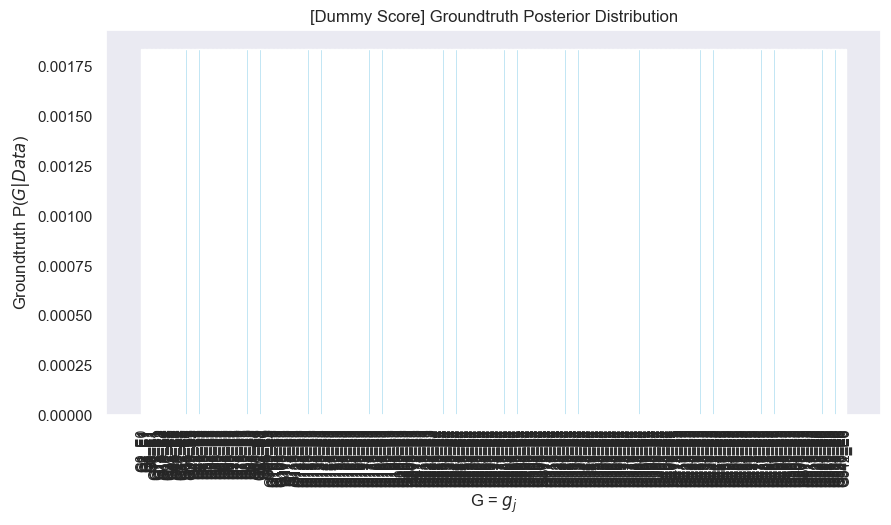

In [28]:
#my_score_str = "BGe Score"

plot_true_posterior_distribution( all_dags, score = 'score_normalised', figsize=(10, 5), 
                                    prob_threshold = 0, 
                                    title = f"[{my_score_str}] Groundtruth Posterior Distribution" )

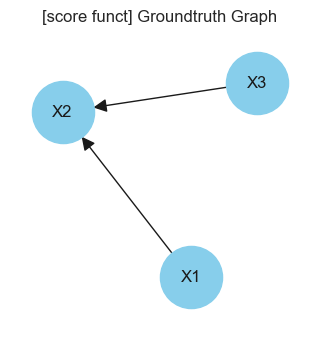

In [16]:
plot_dag_from_true_distr( all_dags, 10)

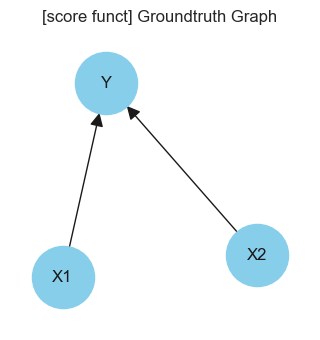

In [9]:
plot_dag_from_true_distr( all_dags, 12)

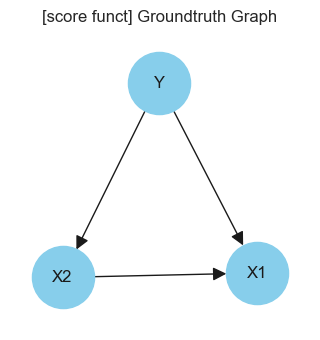

In [10]:
plot_dag_from_true_distr( all_dags, 24)

In [17]:
get_MAP_dags_from_distr(true_posterior_distribution, node_labels= data.columns)

NameError: name 'get_MAP_dags_from_distr' is not defined

## Run Structure MCMC

### Starting with an empty DAG

In [29]:
G_init = nx.DiGraph()

G_init.add_node('X1')
G_init.add_node('X2')

G_init.add_node('Y')

#G_init.add_edge("X1", "Y")
#G_init.add_edge("X2", "Y")
#G_init.add_edge("X2", "X3")



results_analyser = MCMCResultsEngine( )

In [30]:
mcmc_cache = Cache()

burnIn = 0

In [14]:


# Initialize the directed graph with the given nodes
#G_init = nx.DiGraph()
#G_init.add_nodes_from(['X1', 'X2', 'X3', 'Y'])

# Define the edge list
#edges_white = [("X1", "X3")]
#edges_black = [("X1", "X2")]


#black_list = edges_to_adjacency_matrix(edges_black, G_init)
#white_list = edges_to_adjacency_matrix(edges_white, G_init)

#white_list


In [31]:
from scores.dummy import DummyScore


initial_graph = G_init
initial_order = random.choice(all_valid_orderings(initial_graph))
max_iter = 10000

N = len( data.columns )

proposal_object = GraphProposalUniform(initial_graph, whitelist=None, blacklist=None)
score_object = DummyScore( data=data, graph=initial_graph )
#score_object = BGEscoreEfficient( data=data, graph=initial_graph )
#score_object = MarginalLogLikelihood( data=data, graph=initial_graph )

struct_mcmc = StructureMCMC(initial_graph, max_iter, proposal_object, score_object, burnIn)

mcmc_res, accept_rate = struct_mcmc.run()
print(f"ACCEPTANCE RATE = {accept_rate}")

ACCEPTANCE RATE = 0.9631


In [21]:
# compute the approximate posterior distribution
# test
graph_list = struct_mcmc.get_mcmc_res_graphs( mcmc_res )[burnIn:]
approx_posterior_distribution = update_graph_frequencies(graph_list, all_dags)


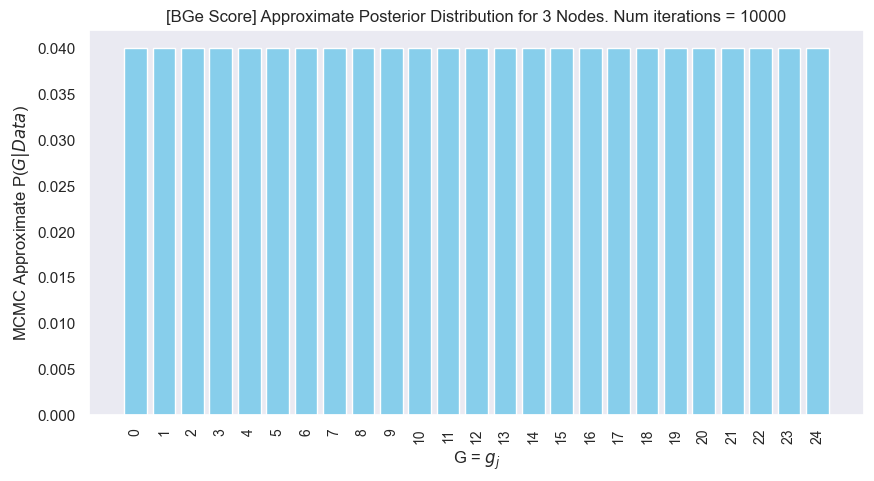

In [23]:
appr_mapper = plot_approx_posterior_distribution(approx_posterior_distribution,  prob_threshold = 0.001, title = f'[{score_object.to_string}] Approximate Posterior Distribution for {len(data.columns)} Nodes. Num iterations = {max_iter}', figsize=(10, 5))


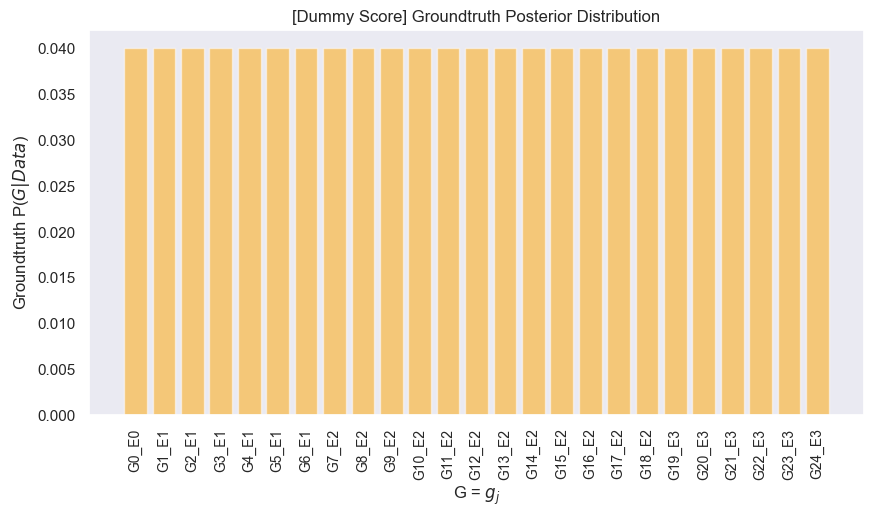

In [24]:
prob_threshold = 0.001
filtered_dags = {k: v for k, v in all_dags.items() if v['score_normalised'] >= prob_threshold}
        
fig, ax = plt.subplots(figsize=(10, 5))
mapper = plot_true_posterior_distribution( filtered_dags, 
                                        score = 'score_normalised', #figsize=(15, 7), 
                                        prob_threshold = prob_threshold, 
                                        title = f"[{my_score_str}] Groundtruth Posterior Distribution", 
                                        alpha=0.5, my_color = 'orange',  ax=ax )

In [63]:
loss = []
for i in range(1, 100):

    graph_list = struct_mcmc.get_mcmc_res_graphs( mcmc_res )[0:i*1000]
    approx_posterior_distribution = update_graph_frequencies(graph_list, N, list(data.columns))
    
    loss.append(  jensen_shannon_divergence( true_posterior_distribution, approx_posterior_distribution ) )

TypeError: update_graph_frequencies() takes 2 positional arguments but 3 were given

Text(0.5, 1.0, 'Augmented MCMC Jensen-Shannon Loss (pi=0.1)')

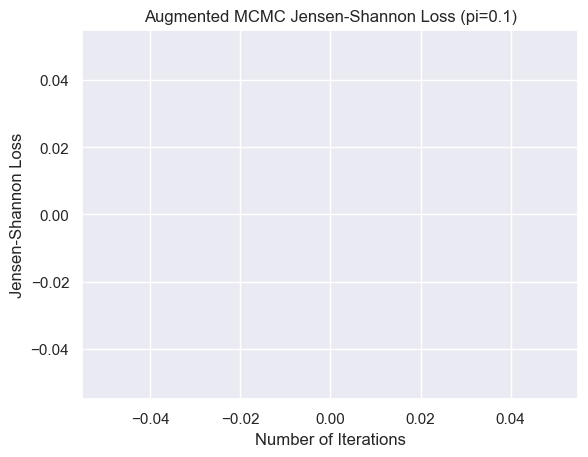

In [64]:
# plot the loss
plt.plot(loss)


plt.xlabel("Number of Iterations")
plt.ylabel("Jensen-Shannon Loss")
plt.title("Augmented MCMC Jensen-Shannon Loss (pi=0.1)")


Text(0.5, 1.0, '[Marginal Likelihood] Augmented MCMC Jensen-Shannon Loss (pi=1)')

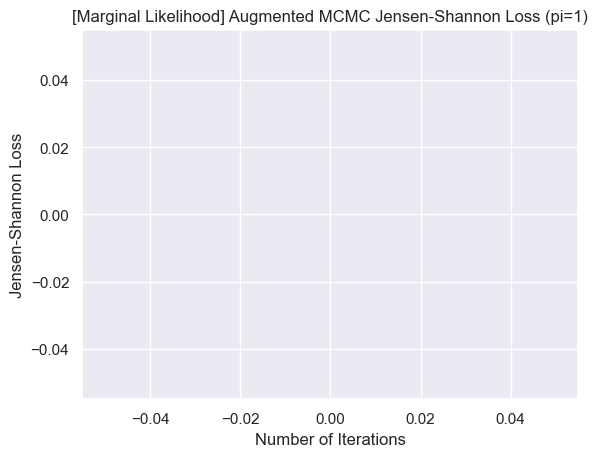

In [65]:
# plot the loss
plt.plot(loss)


plt.xlabel("Number of Iterations")
plt.ylabel("Jensen-Shannon Loss")
plt.title("[Marginal Likelihood] Augmented MCMC Jensen-Shannon Loss (pi=1)")



Text(0.5, 1.0, 'Augmented MCMC Jensen-Shannon Loss (pi=1)')

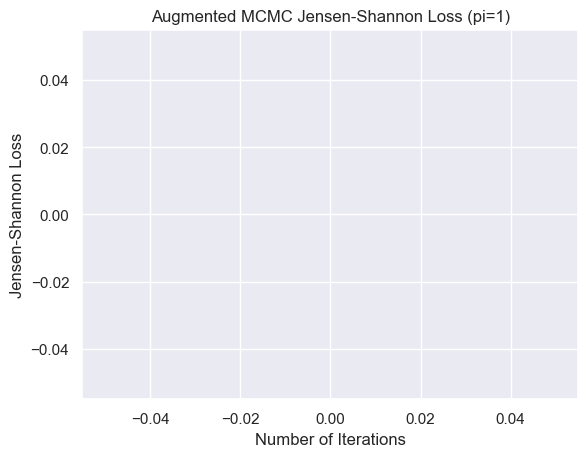

In [66]:
# plot the loss
plt.plot(loss)


plt.xlabel("Number of Iterations")
plt.ylabel("Jensen-Shannon Loss")
plt.title("Augmented MCMC Jensen-Shannon Loss (pi=1)")



In [ ]:
# inspect graphs
ID = 13
plot_graph( adjacency_string_to_digraph( mapper[ID] , 
                                        labels = data.columns), figsize=(3, 3),
                                        title = f"Graph ID = {ID} \nP(G | Data ) = {np.round(approx_posterior_distribution[mapper[ID]], 4)}" )

TypeError: 'NoneType' object is not subscriptable

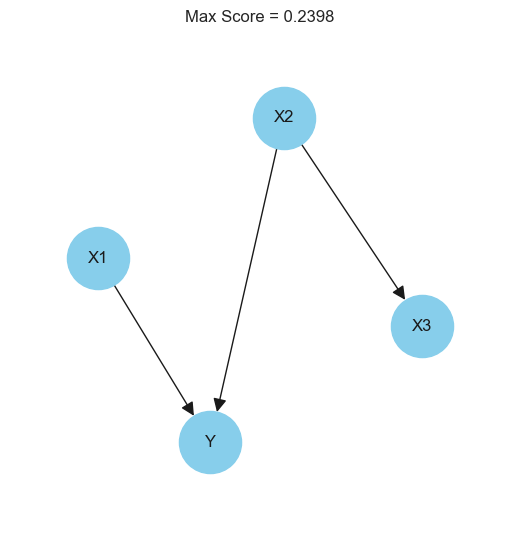

In [94]:
# get max probability graphs
max_score = max(approx_posterior_distribution.values())

max_dags = []
for dag, score in approx_posterior_distribution.items() :
    if score == max_score:
        max_dags.append(dag)


for g_max in max_dags:
    plot_graph( adjacency_string_to_digraph( g_max, labels=list(data.columns) ), figsize=(5, 5), title=f'Max Score = {np.round(max_score, 4)}' )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


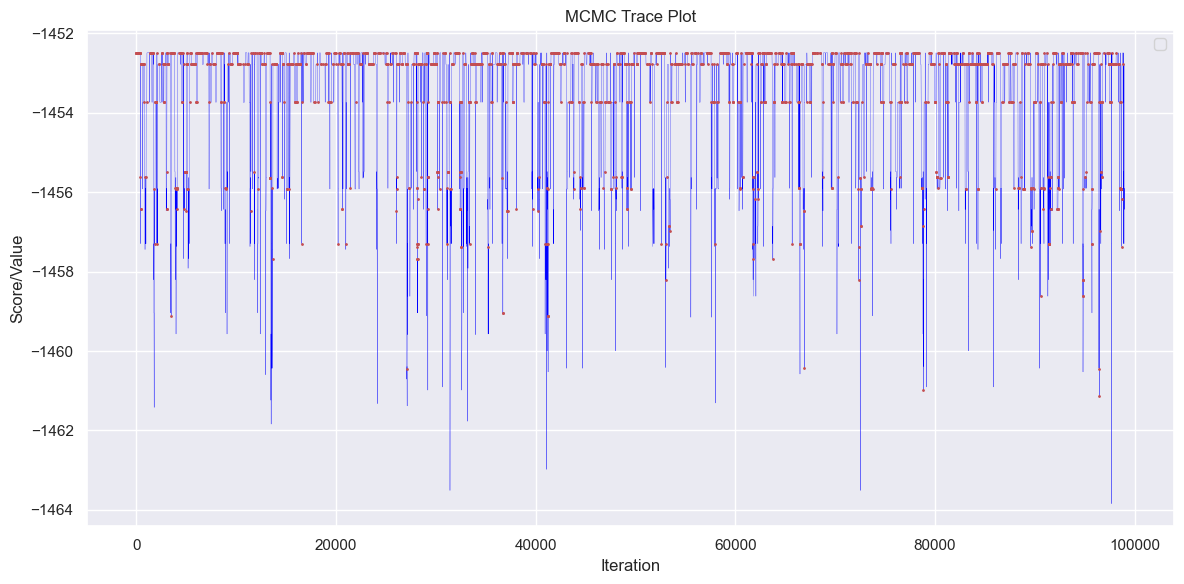

In [90]:
results_analyser.trace_plot(struct_mcmc, mcmc_res, burnIn )


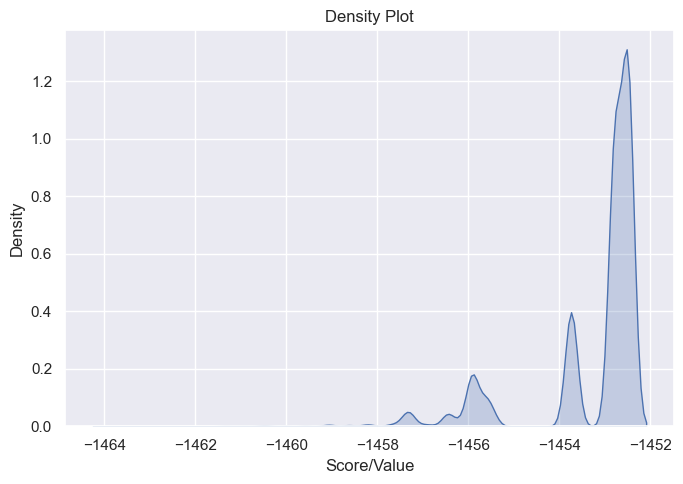

In [91]:
results_analyser.density_plot(struct_mcmc, mcmc_res, burnIn, figsize=(7, 5) )

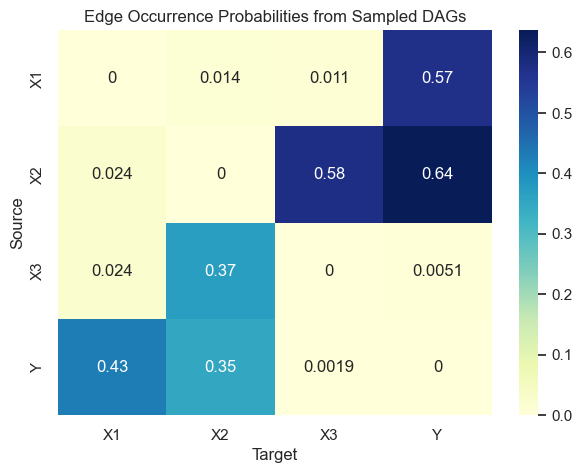

In [92]:
results_analyser.mcmc_edge_frequency_heatmap( struct_mcmc, mcmc_res, burnIn, figsize=(7, 5) )

## Comparing Both Distributions



### Jensen Shannon Divergence

In [93]:
diverg = jensen_shannon_divergence( true_posterior_distribution, approx_posterior_distribution )
diverg

0.0389823833070668

### Mean Square Error

In [71]:
mse = mean_squared_error(true_posterior_distribution, approx_posterior_distribution )
mse

0.01612259297253496

### Mean Absolute Error

In [72]:
mae = mean_absolute_error( true_posterior_distribution, approx_posterior_distribution )
mae

0.4217376647930678

### True Posterior Distribution vs Approximated Posterior Distribution

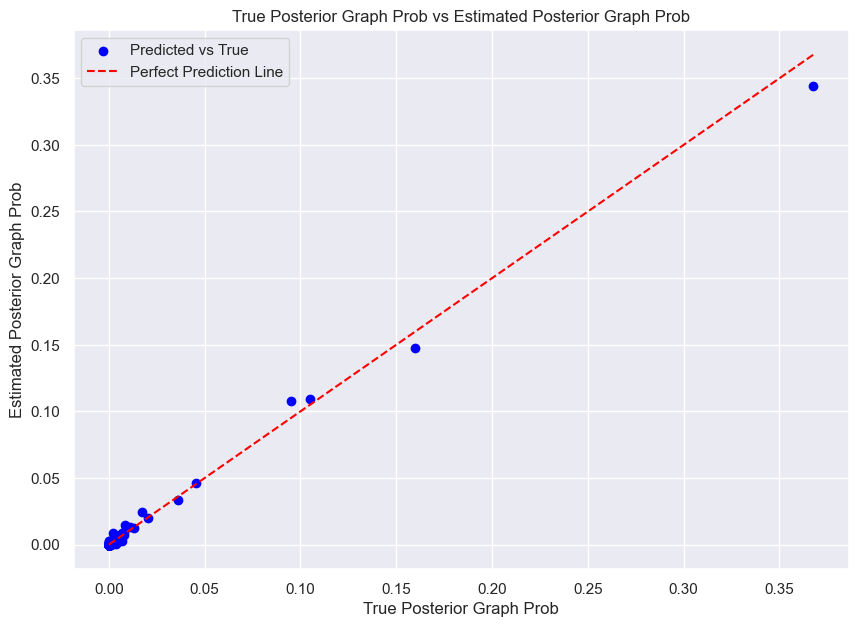

In [ ]:
results_analyser.plot_true_posterior_vs_approx_posterior(true_posterior_distribution, approx_posterior_distribution )


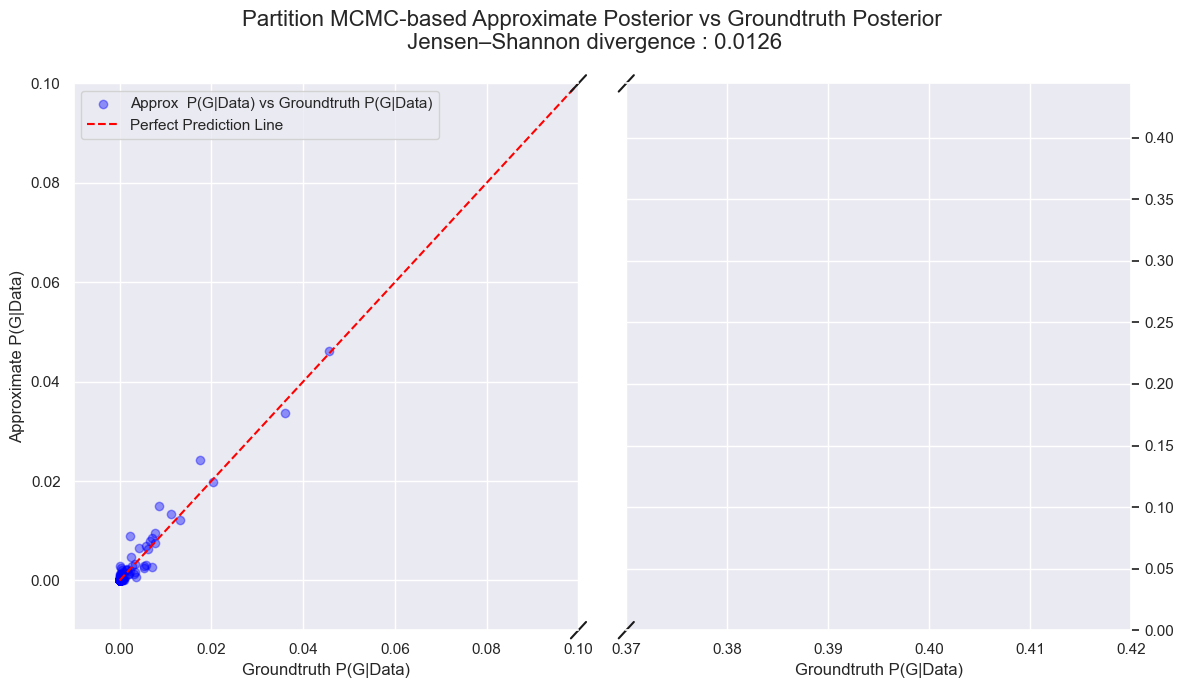

In [ ]:
import matplotlib.gridspec as gridspec



# Create a figure and a gridspec
fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 3])

ZOOM1_X1 = -0.01
ZOOM1_X2 = 0.1

ZOOM1_Y1 = -0.01
ZOOM1_Y2 = 0.1

ax0 = plt.subplot(gs[0])
ax0.scatter(list(true_posterior_distribution.values()), list(approx_posterior_distribution.values()), color='blue', alpha = 0.4,  label='Approx  P(G|Data) vs Groundtruth P(G|Data)')
ax0.set_xlim(ZOOM1_X1, ZOOM1_X2)
ax0.set_ylim(ZOOM1_Y1, ZOOM1_Y2)

ax0.spines['right'].set_visible(False)
ax0.set_ylabel('Approximate P(G|Data)')
ax0.set_xlabel('Groundtruth P(G|Data)')

ax0.plot([min(true_posterior_distribution.values()), max(true_posterior_distribution.values())], 
         [min(true_posterior_distribution.values()), max(true_posterior_distribution.values())], color='red', linestyle='--', label='Perfect Prediction Line')

ax0.grid(True)
plt.legend()


ZOOM2_X1 = 0.37
ZOOM2_X2 = 0.42

# Create the right subplot (0.7 to 1)
ax1 = plt.subplot(gs[1])
ax1.scatter(list(true_posterior_distribution.values()), list(approx_posterior_distribution.values()), color='blue', alpha = 0.4)
ax1.set_xlim(ZOOM2_X1,ZOOM2_X2 )
ax1.set_ylim(min(approx_posterior_distribution.values()), max(approx_posterior_distribution.values())+0.1)
ax1.spines['left'].set_visible(False)
ax1.yaxis.tick_right()
ax1.set_xlabel('Groundtruth P(G|Data)')

ax1.plot([min(true_posterior_distribution.values()), max(true_posterior_distribution.values())], 
         [min(true_posterior_distribution.values()), max(true_posterior_distribution.values())], color='red', linestyle='--', label='Perfect Prediction Line')

ax1.grid(True)

# Adding the "broken" axis effect using diagonals
d = .015
kwargs = dict(transform=ax0.transAxes, color='k', clip_on=False)
ax0.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax0.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax1.transAxes)
ax1.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax1.plot((-d, +d), (-d, +d), **kwargs)

# Title for the entire figure
fig.suptitle(f'Partition MCMC-based Approximate Posterior vs Groundtruth Posterior\n Jensen–Shannon divergence : {np.round(diverg,4)}', fontsize=16)

plt.tight_layout()

plt.show()

# todo, put in a different color the score of the data genrator graph


## Error vs Num Samples

- change the noise
- change the number of samples
- change the number of nodes


### Sample parameters from graph

In [ ]:
G = nx.DiGraph()
G.add_nodes_from(['X1', 'X2', 'X3', 'Y'])
G.add_edges_from((("X1", "Y"),("X2","Y"),("X2","X3")))
DAG = get_adjacency_matrix(G)
n = len(data.columns)
Imat = np.eye(n)
U = pd.DataFrame(Imat, index=data.columns, columns=data.columns)
U

,X1,X2,X3,Y
X1,1.0,0.0,0.0,0.0
X2,0.0,1.0,0.0,0.0
X3,0.0,0.0,1.0,0.0
Y,0.0,0.0,0.0,1.0


In [ ]:
score_object = BGEscore( data=data, graph=G )
rDAG_NIG(1, DAG, score_object, U)['L'][0]

,X1,X2,X3,Y
X1,1.0,0.0,0.000000,-0.819945
X2,0.0,1.0,-0.306811,-0.676914
X3,0.0,0.0,1.000000,0.000000
Y,0.0,0.0,0.000000,1.000000
